MH3110 Team 111 Final Code
==========================

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import pandas as pd
import pyswarms as ps
import statistics

Model
-----

In [2]:
# Define ODE model

# X = Girl's love, Y = Guy's Love, Z = Homesickness
def dXdt(alpha_1, r_1, K_1, theta_1, A_y, X, Y, Z):
    return -alpha_1*X + r_1*Y*(1-Y/K_1) - theta_1*Z + A_y

def dYdt(alpha_2, r_2, K_2, theta_2, A_x, X, Y, Z):
    return -alpha_2*Y + r_2*Z*(1-Z/K_2) + theta_2*X + A_x

def dZdt(alpha_3, beta_3, beta_4, X, Y, Z):
    return -alpha_3*Z + beta_3*X + beta_4*Y

Data
----

In [3]:
# Functions to call, load data and prepare data

def load_data():

    brooklyn2 = pd.read_excel('Data collection for Brooklynn.xlsx', 'Sheet2')
    
    out_df = brooklyn2[['Time (in hours and minutes)', 'Girl\'s Feelings', 'Guy\'s Feelings', 'Home Sickness']]
    out_df.columns = ['t', 'x', 'y', 'z']
    return out_df

def convert_time_to_mins(string):
    string = str(string)
    hours = string.split(':')[0]
    mins = string.split(':')[1]
    
    total_mins = int(hours)*60 + int(mins)
    
    return total_mins

In [4]:
# Call data

data = load_data()
data['t'] = data['t'].apply(convert_time_to_mins)

# Add initial conditions
init_df = pd.DataFrame({'t' : [30], 'x': [0], 'y': [0], 'z': [-10]})
data = pd.concat([init_df, data])

In [5]:
data.head()

,t,x,y,z
0,30,0,0,-10
0,35,0,3,-9
1,40,4,6,-5
2,45,7,8,-3
3,50,8,9,-2


In [6]:
# Adjust time
data['t'] = data['t'] - 30

2020-05-05 22:44:37,741 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


2020-05-05 20:05:07,644 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2020-05-05 20:05:07,645 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2020-05-05 20:05:07,774 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2020-05-05 20:05:07,775 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


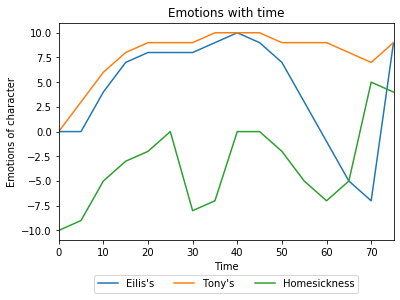

In [7]:
# Plot the data

ax = plt.gca()

data.plot(x="t", y="x", ax=ax, label="Eilis's")
data.plot(x="t", y="y", ax=ax, label="Tony's")
data.plot(x="t", y="z", ax=ax, label="Homesickness")

plt.title("Emotions with time")
plt.ylabel("Emotions of character")
plt.xlabel("Time")
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.2), ncol=3)

plt.savefig("actual_against_t.eps",  bbox_inches = "tight")

Solve System
------------

In [8]:
# Solve the ODE's using odeint
def solve(particle):
    # Set the relevant parameters
    alpha_1 = particle[0]
    d_alpha_1 = particle[1]
    d_alpha_2 = particle[2]
    r_1 =particle[3]
    d_r_1 = particle[4]
    K_1 = particle[5]
    d_K_1 = particle[6]
    beta_4 = particle[7]
    d_beta_4 = particle[8]
    theta_1 = particle[9]
    theta_2 = particle[10]
    A_y = particle[11]
    d_A_y = particle[12]
    
    alpha_2 = alpha_1 + d_alpha_1
    alpha_3 = alpha_2 + d_alpha_2
    r_2 = r_1 + d_r_1
    K_2 = K_1 * d_K_1
    beta_3 = beta_4 + d_beta_4
    A_x = A_y + d_A_y

    U0 = [0, 0, -10]
    
    def dUdt(U, t):
        X = U[0]
        Y = U[1]
        Z = U[2]

        dXdt_var = dXdt(alpha_1, r_1, K_1, theta_1, A_y, X, Y, Z)
        dYdt_var = dYdt(alpha_2, r_2, K_2, theta_2, A_x, X, Y, Z)
        dZdt_var = dZdt(alpha_3, beta_3, beta_4, X, Y, Z)

        return [dXdt_var, dYdt_var, dZdt_var]

    solution = odeint(dUdt, U0, data['t'])
    
    X = solution[:, 0]
    Y = solution[:, 1]
    Z = solution[:, 2]
    return X, Y, Z

PSO
---

In [9]:
# Define error function

def L_error(particles):
    error_lst = [error(i) for i in particles]
    return error_lst

def error(particle):
    X, Y, Z = solve(particle)
    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)
    
    error = np.mean((X-data['x'])**2 + (Y-data['y'])**2 + (Z-data['z'])**2)
    return error

In [10]:
%%capture


# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9} # c1 = cognitive parameters, c2 = social parameters, w = inertia

# Set bounds
#                     alpha_1, d_alpha_1, d_alpha_2, r_1, d_r_1, K_1, d_K_1, beta_4, d_beta_4, theta_1, theta_2   A_y  d_A_y               
constraints = (np.array([1,     0,        3,         0,   0,     5,    0.8,    0,        0,       0,      0,        0,   0]),
               np.array([5,     5,        7,         5,   5,    10,    1.2,    2,        2,       2,      5,        10,  5]))

# Call instance of GlobalBestPSO
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=13, options=options, bounds=constraints)

# Perform optimization
L_stats = optimizer.optimize(L_error, iters=5000)

KeyboardInterrupt: 

In [11]:
# Check Statistics for PSO

mse = L_stats[0]
best_particle = L_stats[1]
cal_mse = error(best_particle)
print('mse: ', mse)
print('cal mse:', cal_mse)

NameError: name 'L_stats' is not defined

In [ ]:
alpha_1 = best_particle[0]
d_alpha_1 = best_particle[1]
d_alpha_2 = best_particle[2]
r_1 = best_particle[3]
d_r_1 = best_particle[4]
K_1 = best_particle[5]
d_K_1 = best_particle[6]
beta_4 = best_particle[7]
d_beta_4 = best_particle[8]
theta_1 = best_particle[9]
theta_2 = best_particle[10]
A_y = best_particle[11]
d_A_y = best_particle[12]

alpha_2 = alpha_1 + d_alpha_1
alpha_3 = alpha_2 + d_alpha_2
r_2 = r_1 + d_r_1
K_2 = K_1 * d_K_1
beta_3 = beta_4 + d_beta_4
A_x = A_y + d_A_y

print("The Finalised Parameters are ")
print("alpha_1:", alpha_1)
print("alpha_2:", alpha_2)
print("alpha_3:", alpha_3)
print("r_1:", r_1)
print("r_2:", r_2)
print("K_1:", K_1)
print("K_2:", K_2)
print("beta_3:", beta_3)
print("beta_4:", beta_4)
print("theta_1:", theta_1)
print("theta_2:", theta_2)
print("A_x:", A_x)
print("A_y:", A_y)

Visualise Solutions
-------------------

In [ ]:
X, Y, Z = solve(best_particle)
print(X,Y,Z)

In [ ]:
plt.plot(data['t'], X, 'g') # Post-PSO ODE
plt.plot(data['t'], data['x']) # Actual data

In [ ]:
plt.plot(data['t'], Y, 'g') # Post-PSO ODE
plt.plot(data['t'], data['y']) # Actual data

In [ ]:
plt.plot(data['t'], Z, 'g') # Post-PSO ODE
plt.plot(data['t'], data['z']) # Actual data

In [ ]:
# Plot all fitted solutions and data on the same plot

plt.plot(data['t'], X, color = 'b', linestyle = '-', label = "Eilis's Fitted")
plt.plot(data['t'], data['x'], color = 'b', linestyle = '--', label = "Eilis's Actual")

plt.plot(data['t'], Y, color = 'orange', linestyle = '-', label = "Tony's Fitted")
plt.plot(data['t'], data['y'], color = 'orange', linestyle = '--', label = "Tony's Actual")

plt.plot(data['t'], Z, color = 'g', linestyle = '-', label = "Homesickness's Fitted")
plt.plot(data['t'], data['z'], color = 'g', linestyle = '--', label = "Homesickness's Actual")

plt.title("Emotions with time")
plt.ylabel("Emotions of character")
plt.xlabel("Time")
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.25), ncol=3)

plt.savefig("actual_fitted.eps",  bbox_inches = "tight")

# Fix Parameters

Comment out the code block below to use new PSO-generated values (i.e. above)in subsequent analysis.

In [7]:
'''
X = [0.,5.27663819,5.2766701,5.2766701,5.2766701,5.2766701, 5.2766701,5.2766701,5.2766701,5.2766701,5.2766701,5.2766701, 5.2766701 ,5.2766701 ,5.2766701 ]
Y=[0.,6.13061656,6.13064506,6.13064506,6.13064506,6.13064506,6.13064506,6.13064506,6.13064506,6.13064506,6.13064506,6.13064506,6.13064506,6.13064506,6.13064506]
Z=[-10.,0.10997115,0.10997202,0.10997202,0.10997202,0.10997202,0.10997202,0.10997202,0.10997202,0.10997202,0.10997202,0.10997202,0.10997202,0.10997202,0.10997202]
'''

soln_lst = [[-7.519434309931023, -5.267421958133589, -0.05583147225366243],[5.08190428494869, 8.246854930714376, 0.044817626180032995]]

alpha_1 = 2.1068759466637026
alpha_2 = 4.480702375732779
alpha_3 = 10.603904799085347
r_1 = 2.993538890437577
r_2 = 6.4339728081914505
K_1 = 8.74468281770518
K_2 = 9.491334454238224
beta_3 = 0.06750530433152813
beta_4 = 0.016028697861847352
theta_1 = 1.215210285112281
theta_2 = 4.753870162072913
A_x = 12.505995545793603
A_y = 9.35597733245975

d_alpha_1 =alpha_2 - alpha_1
d_alpha_2 = alpha_3 - alpha_2 
d_r_1 = r_2-  r_1
d_K_1 = K_2 / K_1 
d_beta_4 = beta_3 - beta_4


Finding Critical Points
-----------------------

In [10]:
from scipy.optimize import fsolve

In [ ]:
def cdXdt(X, Y, Z):
    return -alpha_1*X + r_1*Y*(1-Y/K_1) - theta_1*Z + A_y

def cdYdt(X, Y, Z):
    return -alpha_2*Y + r_2*Z*(1-Z/K_2) + theta_2*X + A_x

def cdZdt(X, Y, Z):
    return -alpha_3*Z + beta_3*X + beta_4*Y

In [ ]:
def equations(p):
    x, y, z = p
    return (cdXdt(x,y,z), cdYdt(x,y,z), cdZdt(x,y,z))

soln_lst = []
nolst = []
for i in np.arange(-100,100,5):
    for j in np.arange(-100,100,5):
        for k in np.arange(-100,100,5):
            x, y, z=  fsolve(equations, (i, j, k))
            soln = [x,y,z]
            soln_norm = np.linalg.norm(soln)
            soln_norm = np.ceil(soln_norm *100)/100
            if soln_norm not in nolst:
                nolst.append(soln_norm)
                if np.abs(cdXdt(x,y,z)) < 0.5 and np.abs(cdYdt(x,y,z)) < 0.5 and np.abs(cdZdt(x,y,z)) < 0.5:
                    soln_lst.append(soln)

for soln in soln_lst:
    x,y,z = soln
    print(cdXdt(x,y,z), cdYdt(x,y,z), cdZdt(x,y,z))

In [ ]:
# Critical Points
soln_lst

# Numerical Simulation (Trajectories)

In [ ]:
# Solve numerically for more trajectories

def dUdt(U, t):
    X = U[0]
    Y = U[1]
    Z = U[2]

    dXdt_var = dXdt(alpha_1, r_1, K_1, theta_1, A_y, X, Y, Z)
    dYdt_var = dYdt(alpha_2, r_2, K_2, theta_2, A_x, X, Y, Z)
    dZdt_var = dZdt(alpha_3, beta_3, beta_4, X, Y, Z)

    return [dXdt_var, dYdt_var, dZdt_var]

U0 = [0, 0, -10]
time = np.linspace(0, 200, 100000)

init_lst = [U0,[-9.515823142290419, -7.408726507183227, -0.07177740561907572]]
trajectory_lst = []

solution = odeint(dUdt, U0, time)

X = solution[:, 0]
Y = solution[:, 1]
Z = solution[:, 2]


In [ ]:
init_lst = []

def traj_calc(init_lst):
    traj_lst = []
    for i in init_lst:
        solved_crit = odeint(dUdt,i,time)
        X = solved_crit[:, 0]
        Y = solved_crit[:, 1]
        Z = solved_crit[:, 2]
        traj_lst.append((X,Y,Z))
    return traj_lst

def populate_init_lst(n):
    """
    within box between [-10,10]^3, populate n evenly distributed points
    """
    out = [(x, y, z) for x in range(-10, 11, 10//n) for y in range(-10, 11, 10//n) for z in range(-10, 11, 10//n)]
    return out

# print(init_lst)
init_lst.append(populate_init_lst(1))
init_lst = init_lst[0]
n_init_lst = np.array(init_lst)
int_lst = n_init_lst.reshape(-1, 3)
"""
for i in int_lst:
    xx,yy,zz = i
    # print(xx,yy,zz)
    ax.plot(xx,yy,zz, 'b')
"""


trajectory_lst = traj_calc(int_lst)


"""
print(init_lst)
print(int_lst)
print(len(trajectory_lst))
"""





# Visualisation of Phase Space / Planes

In [ ]:
from mpl_toolkits.mplot3d import axes3d # Used for the 3d bifurcation plot
import matplotlib.patches as mpatches # used to write custom legends

# Visualise exact X,Y,Z solution
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(X,Y,Z, 'g')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [ ]:
def phase_space_analysis(x,y,z,n,d):
    """
    Input:
    (x,y,z) pair of critical points
    n number of points in a uniform mesh
    d: delta; the neighborhood around x,y,z captured
    
    Returns: phase space around neighborhood +-2 
    
    DANGER: Currently using global variables for alpha_1, d_alpha_2 etc
    DANGER2: Similarly I had to declare global so that the 2D plots below would be more efficient
    """
    
    global x_fl, X_min, X_max, y_fl, Y_min, Y_max, z_fl, Z_min,Z_max
    global tX, tY, tZ 
    
    """
    # Ver 1; arguments
    x_fl = np.floor(x)
    X_min = x_fl - d
    X_max = x_fl + d

    y_fl = np.floor(y)
    Y_min = y_fl -d 
    Y_max = y_fl + d

    z_fl = np.floor(z)
    Z_min = z_fl - d
    Z_max = z_fl + d

    X_n = Y_n = Z_n = n
    """
    

    """
    # Ver 2
    X_min = Y_min = Z_min = -10
    X_max = Y_max = Z_max = 10
    """
    
    # Ver 3; continuous bands
    x_fl = np.floor(x)
    X_min = x - d
    X_max = x + d

    y_fl = np.floor(y)
    Y_min = y -d 
    Y_max = y + d

    z_fl = np.floor(z)
    Z_min = z - d
    Z_max = z + d
    
    tX, tY, tZ = np.meshgrid(np.arange(X_min, X_max, (X_max-X_min)/X_n), np.arange(Y_min, Y_max, (Y_max-Y_min)/Y_n), np.arange(Z_min, Z_max, (Z_max-Z_min)/Z_n))

    # Apply the relevant functions 
    global U
    global V
    global W
    U = dXdt(alpha_1, r_1, K_1, theta_1, A_y, tX, tY, tZ)
    V = dYdt(alpha_2, r_1 + d_r_1, K_1 + d_K_1, theta_2, A_x, tX, tY, tZ)
    W = dZdt(alpha_3, beta_4 + d_beta_4,beta_4, tX, tY, tZ)
    
    # Normalise
    R = np.sqrt(U**2 + V**2 + W**2)
    U = U / R
    V = V / R
    W = W / R

    # from mpl_toolkits.mplot3d import Axes3D; above
    # Static 3D Visualisation
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    
    ax.set_xlim3d(-10,10)
    ax.set_ylim3d(-10,10)
    ax.set_zlim3d(-10,10)
    
    
    
    ax.plot(X,Y,Z, 'g', label = "story", color = 'm')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.legend()
    
    
    for i in trajectory_lst:
        xx,yy,zz = i
        ax.plot(xx,yy,zz, color = 'b', linestyle = ':')
    
    for i in soln_lst:
        x,y,z = i
        ax.scatter(x,y,z,'r')
    
    """
    # Animated 3D visualisation
    from matplotlib import animation
    def init():
        ax.quiver(tX, tY, tZ, U, V, W,length=0.5)
        return fig,

    def animate(i):
        ax.view_init(elev=10., azim=i)
        return fig,

    # Animate
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=360, interval=20, blit=True)
    # Save
    anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
    """

    # ax.quiver(tX, tY, tZ, U, V, W,length=0.5)
    plt.show()
    return

n = X_n = Y_n = Z_n = 3

print(soln_lst)
# trajectory_lst = []

"""
for i in soln_lst:
    x,y,z = i
    phase_space_analysis(x,y,z,n,2)
"""
i = soln_lst[1]
x,y,z = i
phase_space_analysis(x,y,z,n,0.05)


Remark: below set of code is run exactly once for last set of critical points set as of x,y,z 

In [ ]:
i = soln_lst[1]
x,y,z = i
phase_space_analysis(x,y,z,n,0.05)


In [ ]:
# v for visual adjustment
v = 2
mid = int(np.floor(X_n)/2)
plt.figure()

ax = plt.gca()
plt.plot(X,Y,'g', label = 'story')
#plt.legend()


for i in trajectory_lst:
    xx,yy,zz = i
    plt.plot(xx,yy, 'b',linestyle=':')

"""
i = trajectory_lst[3]
xx,yy,zz = i
plt.plot(xx,yy, 'b',linestyle = ':')
"""


plt.xlabel('x')
plt.ylabel('y')
# ax.set_xlim([X_min,X_max])
# ax.set_ylim([Y_min,Y_max])

"""
plt.quiver(tX[:,:,mid], tY[:,:,mid], U[:,:,mid], W[:,:,mid])
"""

plt.show()

In [ ]:
mid = int(np.floor(X_n)/2)
plt.figure()

ax = plt.gca()
plt.xlabel('x')
plt.ylabel('y')
# ax.set_xlim([X_min,X_max])
# ax.set_ylim([Y_min,Y_max])

plt.quiver(tX[:,:,mid], tY[:,:,mid], U[:,:,mid], W[:,:,mid])


plt.show()

In [ ]:
mid = int(np.floor(Y_n)/2)
plt.figure()

ax = plt.gca()
plt.plot(X,Z,'g',label ='story')
plt.xlabel('x')
plt.ylabel('z')
# ax.set_xlim([X_min, X_max])
# ax.set_ylim([Z_min,Z_max])
"""
# plt.quiver(tX[mid,:,:], tZ[mid,:,:], U[mid,:,:], W[mid,:,:])
plt.quiver(tY[:,mid,:], tZ[:,mid,:], V[:,mid,:], W[:,mid,:])
"""

plt.legend()
for i in trajectory_lst:
    xx,yy,zz = i
    plt.plot(xx,zz, 'b',linestyle=':')

plt.show()

In [ ]:
mid = int(np.floor(Y_n)/2)
plt.figure()

ax = plt.gca()
# plt.plot(X,Z,'g')
plt.xlabel('x')
plt.ylabel('z')
# ax.set_xlim([X_min, X_max])
# ax.set_ylim([Z_min,Z_max])
"""
plt.quiver(tY[:,mid,:], tZ[:,mid,:], V[:,mid,:], W[:,mid,:])
"""

plt.quiver(tX[mid,:,:], tZ[mid,:,:], U[mid,:,:], W[mid,:,:])


plt.show()

In [ ]:
mid = int(np.floor(X_n)/2)
plt.figure()

ax = plt.gca()
plt.plot(Y,Z,'g')
plt.xlabel('y')
plt.ylabel('z')
# ax.set_xlim([Y_min,Y_max])
# ax.set_ylim([Z_min,Z_max])

#plt.quiver(tY[:,mid,:], tZ[:,mid,:], V[:,mid,:], W[:,mid,:])

for i in trajectory_lst:
    xx,yy,zz = i
    plt.plot(yy,zz, 'b', linestyle=':')

"""
plt.quiver(tX[mid,:,:], tZ[mid,:,:], U[mid,:,:], W[mid,:,:])
"""

plt.show()

In [ ]:
mid = int(np.floor(X_n)/2)
plt.figure()

ax = plt.gca()
# plt.plot(Y,Z,'g')
plt.xlabel('y')
plt.ylabel('z')
# ax.set_xlim([Y_min,Y_max])
# ax.set_ylim([Z_min,Z_max])

plt.quiver(tY[:,mid,:], tZ[:,mid,:], V[:,mid,:], W[:,mid,:])

"""
plt.quiver(tX[mid,:,:], tZ[mid,:,:], U[mid,:,:], W[mid,:,:])
"""

plt.show()

# Stability Analysis of Critical Points 

In [ ]:
import sympy

# Eigenvalues and Eigenvectors solver
sympy.init_printing(use_latex=True)

# s for symbol prefixed to parameters; to not intefere with prev namespace
sx,sy, sz, sa1, sa2, sa3, sr1, sr2, sK1, sK2, sb3, sb4, st1, st2, sAx, sAy   = sympy.symbols("x, y, z, alpha1,alpha2,alpha3,r1,r2,K1,K2,beta3,beta4,theta1,theta2,A_x,A_y")

sdXdt = -1 * sa1 *sx + sr1 *sy*(1-sy/sK1) - st1*sz + sAy 
sdYdt = -1 * sa2*sy + sr2*sz*(1-sz/sK2) + st2*sx + sAx
sdZdt = -1 * sa3*sz + sb3*sx + sb4*sy

# Symbolic expression of the matrix
sys = sympy.Matrix([sdXdt, sdYdt,sdZdt])
var = sympy.Matrix([sx, sy,sz])
jac = sys.jacobian(var)

# You can convert jac to a numerical function:
ODE_sys_jac1 = sympy.lambdify((sx, sy, sz, sa1, sa2, sa3, sr1, sr2, sK1, sK2, sb3, sb4, st1, st2, sAx, sAy), jac, dummify=False)

# Fix parameters; assume defined

ODE_sys_jac = lambda x,y,z : ODE_sys_jac1(x,y,z, alpha_1,alpha_2,alpha_3, r_1,r_2, K_1,K_2, beta_3, beta_4, theta_1,theta_2,A_x,A_y)

# Subtitute to evaluate Jacobian at point
def list_for_subs(alpha_1,alpha_2,alpha_3, r_1,r_2, K_1,K_2, beta_3, beta_4, theta_1,theta_2,A_x,A_y):
    out = [(sa1,alpha_1),(sa2,alpha_2),(sa3,alpha_3),(sr1,r_1),(sr2,r_2),(sK1,K_1),(sK2,K_2),(sb3,beta_3),(sb4,beta_4),(st1,theta_1),(st2,theta_2),(sAx,A_x),(sAy,A_y)]
    return out

print(alpha_1,alpha_2,alpha_3, r_1,r_2, K_1,K_2, beta_3, beta_4, theta_1,theta_2,A_x,A_y)
print("Check ODE is as in our paper:")
sympy.pprint(sys)
print("Check Jacobian for ODE is correct for our paper:")
sympy.pprint(jac)
print("Simplifying the Jacobian by grouping similar terms:")
sympy.pprint(sympy.simplify(jac))
print("Substituting current parameter values into ODE system:")
sympy.pprint(sys.subs(list_for_subs(alpha_1,alpha_2,alpha_3, r_1,r_2, K_1,K_2, beta_3, beta_4, theta_1,theta_2,A_x,A_y)))
print("Substituting current parameter values into Jacobian:")
sympy.pprint(jac.subs(list_for_subs(alpha_1,alpha_2,alpha_3, r_1,r_2, K_1,K_2, beta_3, beta_4, theta_1,theta_2,A_x,A_y)))


print("\nAnd in latex: \n" + str(sympy.latex(sympy.simplify(jac))))
print("\nAnd in latex: \n" + str(sympy.latex(sys)))

In [ ]:
# Create numerical function for ODE system from symbolic ODE system

ODE_sys_sym1 = sympy.lambdify((sx, sy, sz, sa1, sa2, sa3, sr1, sr2, sK1, sK2, sb3, sb4, st1, st2, sAx, sAy), sys, dummify=False)
ODE_sys_sym = lambda x,y,z : ODE_sys_sym1(x,y,z, alpha_1,alpha_2,alpha_3, r_1,r_2, K_1,K_2, beta_3, beta_4, theta_1,theta_2,A_x,A_y)

In [ ]:
def stability(jacobian):
    """
    Input: (completely numerical) Jacobian matrix
    Returns: Nature of critical point based on case-based analysis
    """
    determinant = np.linalg.det(jacobian)
    trace = np.matrix.trace(jacobian)
    print("determinant: " + str(determinant) + ", trace: " + str(trace))
    crit_eig = np.linalg.eig(list(ODE_sys_jac(x,y,z)))
    crit_eval = crit_eig[0]
    crit_evec =  crit_eig[1]
    def check_stable(eigenval_array):
        for i in eigenval_array:
            if i.real > 0:
                return True
        return False
    def check_asym_stable(eigenval_array):
        for i in eigenval_array:
            if i.real >= 0:
                return True
        return False

    """
    # Ver 1: discarded
    if np.isclose(trace,0) and np.isclose(determinant,0):
        nature = "Center (Hopf)"
    elif np.isclose(determinant,0):
        nature = "Transcritical (Saddle-Node)"
    elif determinant < 0:
        nature = "Saddle"
    else:
        nature = "Stable" if check_any_real_part_pos == False else "Unstable"
        nature += " Spiral" if (trace**2 - 4 * determinant) < 0 else " nodal"
    """
    # Ver 2: 3 dimensions
    if check_stable(crit_eval) == False:
        nature = "Stable"
        if check_asym_stable(crit_eval) == False:
            nature = "Asymptotically Stable"
    else:
        nature = "Unstable"
    return nature

for crit in soln_lst:
    x,y,z = crit
    print("Substituting critical point " + str(crit) + "\ninto the system, we obtain: \n" + str(ODE_sys_sym(x,y,z)))
    print("Substituting into the Jacobian with this point we obtain: \n" + str(ODE_sys_jac(x,y,z)))
    print("The critical point is: " + str(stability(ODE_sys_jac(x,y,z))))
    crit_eig = np.linalg.eig(list(ODE_sys_jac(x,y,z)))
    crit_eval = crit_eig[0]
    crit_evec =  crit_eig[1]
    print("Which has the eigenvalues " + str(crit_eval) + "\n and the eigenvectors: \n" + str(crit_evec))
    print("")
    print("")


Liapunov's second method
------------------------

In [ ]:
from sympy import *
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Translate critical points to the origin
U, S, L = symbols('U S L')
V = U**2 + S**2 + L**2

partialV_partialU = diff(V, U)
partialV_partialS = diff(V, S)
partialV_partialL = diff(V, L)

X = U + soln_lst[1][0]
Y = S + soln_lst[1][1]
Z = L + soln_lst[1][2]

dUdt_symbolic = -alpha_1*X + r_1*Y*(1-Y/K_1) - theta_1*Z + A_y
dSdt_symbolic = -alpha_2*Y + r_2*Z*(1-Z/K_2) + theta_2*X + A_x
dLdt_symbolic = -alpha_3*Z + beta_3*X + beta_4*Y

V_dot = expand(partialV_partialU*dUdt_symbolic + partialV_partialS*dSdt_symbolic + partialV_partialL*dLdt_symbolic)

print(V_dot)

print_latex(V_dot)

Gragani Cyclical Dynamics
-------------------------

In [ ]:
def ode_gragani_dXdt(alpha_1, r_1, K_1, theta_1, A_y, X, Y, Z):
    return -alpha_1*X + r_1*Y*(1-Y/K_1) - theta_1*Z + A_y

def ode_gragani_dYdt(alpha_2, r_2, K_2, theta_2, A_x, lambda_1, lambda_2, X, Y, Z):
    return -alpha_2*Y + r_2*Z*(1-Z/K_2) + theta_2*X + A_x*(1+1/(np.e**(-lambda_1*Y+lambda_2)+1))

def ode_gragani_dZdt(alpha_3, beta_3, beta_4, X, Y, Z):
    return -alpha_3*Z + beta_3*X + beta_4*Y

In [ ]:
def solve_gragani(particle):
    # Set the relevant parameters
    alpha_1 = particle[0]
    d_alpha_1 = particle[1]
    d_alpha_2 = particle[2]
    r_1 =particle[3]
    d_r_1 = particle[4]
    K_1 = particle[5]
    d_K_1 = particle[6]
    beta_4 = particle[7]
    d_beta_4 = particle[8]
    theta_1 = particle[9]
    theta_2 = particle[10]
    lambda_1 = particle[11]
    lambda_2 = particle[12]
    A_y = particle[13]
    d_A_y = particle[14]
    
    alpha_2 = alpha_1 + d_alpha_1
    alpha_3 = alpha_2 + d_alpha_2
    r_2 = r_1 + d_r_1
    K_2 = K_1 * d_K_1
    beta_3 = beta_4 + d_beta_4
    A_x = A_y + d_A_y

    U0 = [0, 0, -10]
    
    def dUdt(U, t):
        X = U[0]
        Y = U[1]
        Z = U[2]

        dXdt_var_gragani = ode_gragani_dXdt(alpha_1, r_1, K_1, theta_1, A_y, X, Y, Z)
        dYdt_var_gragani = ode_gragani_dYdt(alpha_2, r_2, K_2, theta_2, A_x, lambda_1, lambda_2, X, Y, Z)
        dZdt_var_gragani = ode_gragani_dZdt(alpha_3, beta_3, beta_4, X, Y, Z)

        return [dXdt_var_gragani, dYdt_var_gragani, dZdt_var_gragani]

    solution = odeint(dUdt, U0, data['t'])
    
    X = solution[:, 0]
    Y = solution[:, 1]
    Z = solution[:, 2]
    return X, Y, Z

In [ ]:
# Define error function

def L_error(particles):
    error_lst = [error(i) for i in particles]
    return error_lst

def error(particle):
    X, Y, Z = solve_gragani(particle)
    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)
    
    error = np.mean((X-data['x'])**2 + (Y-data['y'])**2 + (Z-data['z'])**2)
    return error

In [ ]:
%%capture


# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9} # c1 = cognitive parameters, c2 = social parameters, w = inertia

# Set bounds
#                     alpha_1, d_alpha_1, d_alpha_2, r_1, d_r_1, K_1, d_K_1, beta_4, d_beta_4, theta_1, theta_2, lambda_1, lambda_2, A_y  d_A_y               
constraints = (np.array([1,     0,        3,         0,   0,     5,    0.8,    0,        0,       0,      0,        0,         0,     0,   0]),
               np.array([5,     5,        7,         5,   5,    10,    1.2,    2,        2,       2,      5,       10,        10,    10,   5]))

# Call instance of GlobalBestPSO
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=15, options=options, bounds=constraints)

# Perform optimization
L_stats = optimizer.optimize(L_error, iters=1000)

In [ ]:
# Check Statistics for PSO

mse = L_stats[0]
best_particle = L_stats[1]
cal_mse = error(best_particle)
print('mse: ', mse)
print('cal mse:', cal_mse)

In [ ]:
alpha_1 = best_particle[0]
d_alpha_1 = best_particle[1]
d_alpha_2 = best_particle[2]
r_1 = best_particle[3]
d_r_1 = best_particle[4]
K_1 = best_particle[5]
d_K_1 = best_particle[6]
beta_4 = best_particle[7]
d_beta_4 = best_particle[8]
theta_1 = best_particle[9]
theta_2 = best_particle[10]
lambda_1 = best_particle[11]
lambda_2 = best_particle[12]
A_y = best_particle[13]
d_A_y = best_particle[14]

alpha_2 = alpha_1 + d_alpha_1
alpha_3 = alpha_2 + d_alpha_2
r_2 = r_1 + d_r_1
K_2 = K_1 * d_K_1
beta_3 = beta_4 + d_beta_4
A_x = A_y + d_A_y

print("The Finalised Parameters are ")
print("alpha_1:", alpha_1)
print("alpha_2:", alpha_2)
print("alpha_3:", alpha_3)
print("r_1:", r_1)
print("r_2:", r_2)
print("K_1:", K_1)
print("K_2:", K_2)
print("beta_3:", beta_3)
print("beta_4:", beta_4)
print("theta_1:", theta_1)
print("theta_2:", theta_2)
print("lambda_1: ", lambda_1)
print("lambda_2: ", lambda_2)
print("A_x:", A_x)
print("A_y:", A_y)

In [ ]:
X, Y, Z = solve_gragani(best_particle)
print(X,Y,Z)

In [ ]:
plt.plot(data['t'], X, 'g') # Post-PSO ODE
plt.plot(data['t'], data['x']) # Actual data

In [ ]:
plt.plot(data['t'], Y, 'g') # Post-PSO ODE
plt.plot(data['t'], data['y']) # Actual data

In [ ]:
plt.plot(data['t'], Z, 'g') # Post-PSO ODE
plt.plot(data['t'], data['z']) # Actual data

In [ ]:
# Plot all fitted solutions and data on the same plot

plt.plot(data['t'], X, color = 'b', linestyle = '-', label = "Eilis's Fitted")
plt.plot(data['t'], data['x'], color = 'b', linestyle = '--', label = "Eilis's Actual")

plt.plot(data['t'], Y, color = 'orange', linestyle = '-', label = "Tony's Fitted")
plt.plot(data['t'], data['y'], color = 'orange', linestyle = '--', label = "Tony's Actual")

plt.plot(data['t'], Z, color = 'g', linestyle = '-', label = "Homesickness's Fitted")
plt.plot(data['t'], data['z'], color = 'g', linestyle = '--', label = "Homesickness's Actual")

plt.title("Emotions with time")
plt.ylabel("Emotions of character")
plt.xlabel("Time")
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.25), ncol=3)

plt.savefig("actual_fitted_gragani.eps",  bbox_inches = "tight")

Regression Solver
-----------------

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# Create x^2 and z^2

data['y2'] = data['y']**2
data['z2'] = data['z']**2

In [ ]:
data.reset_index(drop=True, inplace=True)

In [ ]:
# create dx, dy, dz
x_lag_1 = data['x'].diff().reset_index(drop=True).loc[1:].reset_index(drop=True).copy()
y_lag_1 = data['y'].diff().reset_index(drop=True).loc[1:].reset_index(drop=True).copy()
z_lag_1 = data['z'].diff().reset_index(drop=True).loc[1:].reset_index(drop=True).copy()

time_diff = data['t'].diff().reset_index(drop=True).loc[1:].reset_index(drop=True).copy()

data = data.loc[:14]

data['x_lag_1'] = x_lag_1
data['y_lag_1'] = y_lag_1
data['z_lag_1'] = z_lag_1
data['time_diff'] = time_diff

data['dx'] = data['x_lag_1']/data['time_diff']
data['dy'] = data['y_lag_1']/data['time_diff']
data['dz'] = data['z_lag_1']/data['time_diff']

In [ ]:
x_df = data[['x', 'y', 'y2', 'z', 'dx']]
y_df = data[['x', 'y', 'z', 'z2', 'dy']]
z_df = data[['x', 'y', 'z', 'dz']]

In [ ]:
XX = data[['x', 'y', 'y2', 'z']]
yy = data['dx']

lm = LinearRegression()
lm.fit(XX,yy)
predicted_dx = lm.predict(XX)

predicted_x = data['x'] + predicted_dx*data['time_diff']
predicted_x = predicted_x[:-1]
predicted_x = np.insert(predicted_x.values, 0, np.nan)
data['predicted_x'] = predicted_x

plt.plot(data['t'], data['x'], color='blue')
plt.plot(data['t'], data['predicted_x'], color='red')
plt.xlabel('time')
plt.ylabel('X')
plt.savefig('linearreg_data_predicted_X.eps')


B0_dx = lm.intercept_
B1_dx, B2_dx, B3_dx, B4_dx = lm.coef_

In [ ]:
XX = data[['x', 'y', 'z', 'z2']]
yy = data['dy']

lm = LinearRegression()
lm.fit(XX,yy)
predicted_dy = lm.predict(XX)

predicted_y = data['y'] + predicted_dy*data['time_diff']
predicted_y = predicted_y[:-1]
predicted_y = np.insert(predicted_y.values, 0, np.nan)
data['predicted_y'] = predicted_y

plt.plot(data['t'], data['y'],color='blue')
plt. plot(data['t'], data['predicted_y'],color='red')
plt.xlabel('time')
plt.ylabel('Y')
plt.savefig('linearreg_data_predicted_Y.eps')

B0_dy = lm.intercept_
B1_dy, B2_dy, B3_dy, B4_dy = lm.coef_

In [ ]:
XX = data[['x', 'y', 'z']]
yy = data['dz']

lm = LinearRegression(fit_intercept=False)
lm.fit(X,y)
predicted_dz = lm.predict(X)

predicted_z = data['z'] + predicted_dz*data['time_diff']
predicted_z = predicted_z[:-1]
predicted_z = np.insert(predicted_z.values, 0, np.nan)
data['predicted_z'] = predicted_z

plt.plot(data['t'], data['z'], color='blue')
plt.plot(data['t'], data['predicted_z'], color='red')
plt.xlabel('time')
plt.ylabel('Z')
plt.savefig('linearreg_data_predicted_Z.eps')


B1_dz, B2_dz, B3_dz = lm.coef_

In [ ]:
A_y = B0_dx
A_x = B0_dy

# beta_1 = B0_dx/A_y
alpha_1 = -B1_dx
r_1 = B2_dx
K_1 = -r_1/B3_dx
theta_1 = -B4_dx

# beta_2 = B0_dy/A_y
theta_2 = B1_dy
alpha_2 = -B2_dy
r_2 = B3_dy
K_2 = -r_2/B4_dy

beta_3 = B1_dz
beta_4 = B2_dz
alpha_3 = -B3_dz

details = ''
# details += 'beta_1: {}\n'.format(beta_1)
details += 'alpha_1: {}\n'.format(alpha_1)
details += 'r_1: {}\n'.format(r_1)
details += 'K_1: {}\n'.format(K_1)
details += 'theta_1: {}\n'.format(theta_1)

# details += 'beta_2: {}\n'.format(beta_2)
details += 'theta_2: {}\n'.format(theta_2)
details += 'alpha_2: {}\n'.format(alpha_2)
details += 'r_2: {}\n'.format(r_2)
details += 'K_2: {}\n'.format(K_2)

details += 'alpha_3: {}\n'.format(alpha_3)
details += 'beta_3: {}\n'.format(beta_3)
details += 'beta_4: {}\n'.format(beta_4)

print(details)

In [ ]:
U0 = [0, 0, -10]
def dXdt(alpha_1, r_1, K_1, theta_1, A_y, X, Y, Z):
    return -alpha_1*X + r_1*Y*(1-Y/K_1) - theta_1*Z + A_y

def dYdt(alpha_2, r_2, K_2, theta_2, A_x, X, Y, Z):
    return -alpha_2*Y + r_2*Z*(1-Z/K_2) + theta_2*X + A_x

def dZdt(alpha_3, beta_3, beta_4, X, Y, Z):
    return -alpha_3*Z + beta_3*X + beta_4*Y
def dUdt(U, t):
    X = U[0]
    Y = U[1]
    Z = U[2]

    dXdt_var = dXdt(alpha_1, r_1, K_1, theta_1, A_y, X, Y, Z)
    dYdt_var = dYdt(alpha_2, r_2, K_2, theta_2, A_x, X, Y, Z)
    dZdt_var = dZdt(alpha_3, beta_3, beta_4, X, Y, Z)

    return [dXdt_var, dYdt_var, dZdt_var]
    
solution = odeint(dUdt, U0, data['t'])

In [ ]:
mse = np.mean(((solution - data[['x','y','z']])**2).to_numpy())
print('mse: ', mse)

In [ ]:
plt.plot(data['t'],solution[:,0], color='green')
plt.plot(data['t'],data['x'], color='red')

plt.xlabel('time')
plt.ylabel('X')
plt.legend(['generated','observed'])
plt.savefig('generated_observed_linearreg_X.eps')

In [ ]:
plt.plot(data['t'],solution[:,1], color='green')
plt.plot(data['t'],data['y'], color='red')

plt.xlabel('time')
plt.ylabel('Y')
plt.legend(['generated','observed'])
plt.savefig('generated_observed_linearreg_Y.eps')

In [ ]:
plt.plot(data['t'],solution[:,2], color='green')
plt.plot(data['t'],data['z'], color='red')

plt.xlabel('time')
plt.ylabel('Z')
plt.legend(['generated','observed'])
plt.savefig('generated_observed_linearreg_Z.eps')

# Basin of Attraction (Numerical)


In [ ]:
# Recalculation of more trajectories in [-10,10]^3 box
init_lst = []

def traj_calc(init_lst):
    traj_lst = []
    for i in init_lst:
        solved_crit = odeint(dUdt,i,time)
        X = solved_crit[:, 0]
        Y = solved_crit[:, 1]
        Z = solved_crit[:, 2]
        traj_lst.append((X,Y,Z))
    return traj_lst

def populate_init_lst(n,xlim,ylim,zlim):
    """
    within box between [-10,10]^3, populate n evenly distributed points
    """
    out = [(x, y, z) for x in range(-xlim, xlim + 10//n, (2*xlim)//n) for y in range(-ylim, ylim + 10//n, (2*ylim)//n) for z in range(-zlim, zlim + 10//n, (2*zlim)//n)]
    return out
xlim=10
ylim=zlim=10
# print(init_lst)
init_lst.append(populate_init_lst(20,xlim,ylim,zlim))
n_init_lst = np.array(init_lst)
int_lst = n_init_lst.reshape(-1, 3)

trajectory_lst = traj_calc(int_lst)

In [ ]:
def divergent_class(traj_lst, xlim,ylim,zlim):
    """
    input a set of xlim, ylim, zlim in which any greater, we say it is a divergent point.
    return: 0 if not divergent, elsae return 1 for points going to infinity
    """
    class_out = []
    for traj in traj_lst:
        if np.abs(traj[0][-1]) >= xlim or np.abs(traj[1][-1]) >= ylim or np.abs(traj[2][-1]) >= zlim:
            class_out.append(1)
        else:
            class_out.append(0)
    return class_out




div_class = np.array(divergent_class(trajectory_lst,6,9,1))

from mpl_toolkits.mplot3d import axes3d # Used for the 3d bifurcation plot
import matplotlib.patches as mpatches # used to write custom legends
from matplotlib import pyplot as plt

# Visualise exact X,Y,Z solution
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')




In [ ]:
test = int_lst.ravel()
X_lst = []
Y_lst = []
Z_lst = []
for i in range(len(test)):
    if i%3 == 0:
        X_lst.append(test[i])
    elif i%3 ==1:
        Y_lst.append(test[i])
    elif i%3 ==2:
        Z_lst.append(test[i])
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_lst,Y_lst,Z_lst, c = div_class)
plt.savefig('test')




# Lyapunov Exponents and Strange or Not?

In [10]:
# Solve numerically for more trajectories

def dUdt(U, t):
    X = U[0]
    Y = U[1]
    Z = U[2]

    dXdt_var = dXdt(alpha_1, r_1, K_1, theta_1, A_y, X, Y, Z)
    dYdt_var = dYdt(alpha_2, r_2, K_2, theta_2, A_x, X, Y, Z)
    dZdt_var = dZdt(alpha_3, beta_3, beta_4, X, Y, Z)

    return [dXdt_var, dYdt_var, dZdt_var]

U0 = [0, 0, -10]
time = np.linspace(0, 200, 30)

init_lst = [U0,[-9.515823142290419, -7.408726507183227, -0.07177740561907572]]
trajectory_lst = []

solution = odeint(dUdt, U0, time)

X = solution[:, 0]
Y = solution[:, 1]
Z = solution[:, 2]



In [43]:
time = np.linspace(0, 117, 20)

solution = odeint(dUdt, U0, time)

X = solution[:, 0]
Y = solution[:, 1]
Z = solution[:, 2]

lya_x_sum =0
lya_y_sum =0
lya_z_sum =0

dev = 0.001
num_points = len(X)

dev_v = np.array([dev,0,0])
for i in range(0,num_points-1):
    # Take new initial point based on deviation
    lya_sol = odeint(dUdt, np.array([X[i],Y[i],Z[i]]) + dev_v, time)
    lya_X = lya_sol[:, 0]
    
    # calculate lyapunov
    line = np.abs((X[i]-lya_X[i])/time[1])
    if np.abs(line/time[1]) >= 1e-100:
        lya_x_sum = lya_x_sum + np.log(np.abs((X[i]-lya_X[i])/time[1]))/((num_points-1)*time[1])
    #print(lya_x_sum)
    
    # Update the normalised vector.
    dev_v = lya_sol[-1]/ np.sqrt(np.sum(lya_sol[-1]**2)) * dev

dev_v = np.array([0,dev,0])
for i in range(0,num_points-1):
    # Take new initial point based on deviation
    lya_sol = odeint(dUdt, np.array([X[i],Y[i],Z[i]]) + dev_v, time)
    lya_Y = lya_sol[:, 1]
    
    # calculate lyapunov
    line = np.abs((Y[i]-lya_Y[i])/time[1])
    if np.abs(line/time[1]) >= 1e-100:
        lya_y_sum = lya_y_sum + np.log(np.abs((Y[i]-lya_Y[i])/time[1]))/((num_points-1)*time[1])
    # Update the normalised vector.
    dev_v = lya_sol[-1]/ np.sqrt(np.sum(lya_sol[-1]**2)) * dev

dev_v = np.array([0,0,dev])
for i in range(0,num_points-1):
    # Take new initial point based on deviation
    lya_sol = odeint(dUdt, np.array([Z[i],Y[i],Z[i]]) + dev_v, time)
    lya_Z = lya_sol[:, 2]
    
    # calculate lyapunov
    line = np.abs((Z[i]-lya_Z[i])/time[1])
    if np.abs(line/time[1]) >= 1e-100:
        lya_z_sum = lya_z_sum + np.log(np.abs((Z[i]-lya_Z[i])/time[1]))/((num_points-1)*time[1])
    
    # Update the normalised vector.
    dev_v = lya_sol[-1]/ np.sqrt(np.sum(lya_sol[-1]**2)) * dev



# print(lya_x_sum)
print([lya_x_sum, lya_y_sum, lya_z_sum])


[-4.954458772398709, -3.4325334105517507, -5.624361336008295]


In [12]:
time[1]

13.0